<a id='top'></a>

# CSCI 3202: Intro to AI - Fall 2020 Practicum 2

## Your name: Jacob (Jake) Henson - 105963531

#### Collaborator's name (optional): N/A


---
**Shortcuts:**  [Problem 1: Search](#p1) | [Problem 2: MDP](#p2) | [Problem 3: Q_Learn](#bot)

---

This practicum is due on Canvas by **10:00 PM on Saturday December 12**. Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.  Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  

**Here are the rules:** 

1. All work, code and analysis, must be your own. 
2. You may use your course notes, posted lecture slides, textbooks, in-class notebooks, and homework solutions as resources.  You may also search online for answers to general knowledge questions like the form of a probability distributions or how to perform a particular operation in Python/Pandas. 
3. This is meant to be like a coding portion of your final exam. So, the instructional team will be much less helpful than we typically are with homework. For example, we will not check answers, help debug your code, and so on.
4. If something is left open-ended, it is because we want to see how you approach the kinds of problems you will encounter in the wild, where it will not always be clear what sort of tests/methods should be applied. Feel free to ask clarifying questions though.
5. You may **NOT** post to message boards or other online resources asking for help.  If you have a question for us, post it as a **PRIVATE** message on Piazza.  If we decide that the question is appropriate for the entire class, then we will add it to a Practicum clarifications thread. 
6. You may re-use your code or code given from in-class solutions (for e.g. Astar, MDP), but you **must cite** in comments any regions of code that were not created anew for this practicum.
7. You may collaborate with **exactly one** of your classmates.  You must each submit your own assignments and write your own code, and may only collaborate on ideas, psuedocode, etc.  If you choose to collaborate with another student in the class, list their name under yours above.
8. In short, **your work must be your own**. It really is that simple.

Violation of the above rules will result in an immediate academic sanction (*at the very least*, you will receive a 0 on this practicum or an F in the course, depending on severity), and a trip to the Honor Code Council.

**By submitting this assignment, you agree to abide by the rules given above.**

***

**NOTES**: 

- You may not use late days on the practicums nor can you drop your practicum grades.
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc. 
- This should go without saying, but... For any question that asks you to calculate something, you **must show all work to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit.
***


In [1]:
import pandas as pd
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors


Consider the map of the area to the west of the Engineering Center given below, with a fairly coarse Cartesian grid superimposed.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/engineering_center_grid_zoom.png" style="width: 800px;"/>

The green square at $(x,y)=(1,15)$ is the starting location, and you would like to walk from there to the yellow square at $(25,9)$. The filled-in blue squares are obstacles, and you cannot walk through those locations.  You also cannot walk outside of this grid.

Legal moves in the North/South/East/West directions have a step cost of 1. Moves in the diagonal direction (for example, from $(1,15)$ to $(2,14)$) are allowed, but they have a step cost of $\sqrt{2}$. 


In [2]:
#Some tuples defining the wall and state locations, for your convenience

walls = [(1,y) for y in range(2,15)] + [(2,y) for y in range(3,14)] + [(3,y) for y in range(4,13)] + \
        [(4,y) for y in range(5,12)] + [(x,1) for x in range(5,24)] + [(10,y) for y in range(9,13)] + \
        [(x,y) for x in range(11,14) for y in range(9,15)] + [(14,y) for y in range(11,15)] + \
        [(x,y) for x in range(21,26) for y in range(11,17)] + \
        [(x,y) for x in [0,26] for y in range(0,18)] + [(x,y) for x in range(0,26) for y in [0,17]]
        
states = [(x,y) for x in range(1,26) for y in range(1,17)]

[Back to top](#top)
<a id='p1'></a>


---
## [40 pts] Part 1:  Route-finding
In this problem, our goal is to find the path from the green to yellow squares with the **shortest total path length**.

Of course, you can probably do this problem (and likely have to some degree, in your head) without a search algorithm. But that will hopefully provide a useful "sanity check" for your answer.

#### Part A
Write a function `adjacent_states(state)`:
* takes a single argument `state`, which is a tuple representing a valid state in this state space
* returns in some form the states reachable from `state` and the step costs. How exactly you do this is up to you.

Print to the screen the output for `adjacent_states((1,15))`.

In [3]:
#redefine number of total rows and columns for easy access 
nrows = max(states)[1]
ncols = max(states)[0]
#print(nrows, ncols)

def adjacent_states(state):
    #check 8 possible combinations of movement 
    x = state[0]
    y = state[1]
    neighbors = {} #empty dictionary to store neighboring values 
    
    
    #check if wall, failsafe 
    if((x,y) in walls):
        return {};
    
    #North
    if(y+1 <= nrows and (x, y+1) not in walls):
        neighbors.update({(x, y+1): 1}) #append N, pathcost 1 
    #NorthEast
    if((x+1, y+1) <= (nrows, ncols) and (x+1, y+1) not in walls):
        neighbors.update({(x+1, y+1): np.sqrt(2)}) #append NE, pathcost sqrt(2)
    #East
    if(x+1 <= ncols and (x+1, y) not in walls):
        neighbors.update({(x+1, y): 1}) #append E, pathcost 1
    #SouthEast
    if(x+1 < ncols and y-1 > 0 and (x+1, y-1) not in walls):
        neighbors.update({(x+1, y-1): np.sqrt(2)}) #append SE, pathcost sqrt(2)
    #South
    if(y-1 > 0 and (x, y-1) not in walls):
        neighbors.update({(x, y-1): 1}) #append S, pathcost 1      
    #SouthWest
    if((x-1, y-1) > (0, 0) and (x-1, y-1) not in walls):
        neighbors.update({(x-1,y-1): np.sqrt(2)}) #append SW, pathcost, pathcost sqrt(2)
    #West
    if(x-1 > 0 and (x-1, y) not in walls):
        neighbors.update({(x-1, y): 1}) #append W, pathcost 1
    #NorthWest
    if(x-1 > 0 and y+1 <= nrows and (x-1, y+1) not in walls):
        neighbors.update({(x-1,y+1): np.sqrt(2)}) #append NW, pathcost, pathcost sqrt(2)    
    
    return neighbors


print("Neighbors of (2,2) are:", adjacent_states((2,2)))
print("Neighbors of (1,1) are:", adjacent_states((2,2)))
print("Neighbors of (25,5) are:", adjacent_states((2,2)))

Neighbors of (2,2) are: {(3, 3): 1.4142135623730951, (3, 2): 1, (3, 1): 1.4142135623730951, (2, 1): 1, (1, 1): 1.4142135623730951}
Neighbors of (1,1) are: {(3, 3): 1.4142135623730951, (3, 2): 1, (3, 1): 1.4142135623730951, (2, 1): 1, (1, 1): 1.4142135623730951}
Neighbors of (25,5) are: {(3, 3): 1.4142135623730951, (3, 2): 1, (3, 1): 1.4142135623730951, (2, 1): 1, (1, 1): 1.4142135623730951}


#### Part B
Three candidate heuristic functions might be:
1. `heuristic_cols(state, goal)` = number of columns between the argument `state` and the `goal`
1. `heuristic_rows(state, goal)` = number of rows between the argument `state` and the `goal`
1. `heuristic_eucl(state, goal)` = Euclidean distance between the argument `state` and the `goal`

Write a function `heuristic_max(state, goal)` that returns the maximum of all three of these heuristic functions for a given `state` and `goal`.

In [4]:
#pretty simple. I hope this should be an absolute value 
def heuristic_cols(state, goal):
    return abs(goal[0] - state[0])

#pretty simple. I hope this should be an absolute value 
def heuristic_rows(state, goal):
    return abs(goal[1] - state[1])

#returns euclid distance. unsure if it should be abs(goal[0]-state[0]) but this seems to work...  
def heuristic_eucl(state, goal):
    #euclid distance == sqrt((x1-x2)^2 + (y1,y2)^2)
    return np.sqrt((goal[0] - state[0])**2 + (goal[1] - state[1])**2)

#get the max of the three heuristics, return it 
def heuristic_max(state, goal):
    h_cols = heuristic_cols(state, goal)
    h_rows = heuristic_rows(state, goal)
    h_eucl = heuristic_eucl(state, goal)
                            
    return max(h_cols, h_rows, h_eucl)
#

#### Part C
Is the Manhattan distance an admissible heuristic function for this problem?  Explain why or why not.

**A heuristic is only admissible if it NEVER overestimates the actual path cost. In this case, Manhattan distance heuristic overestimates the pathcost cost, because it does not account for a pathcost of moving diagonally as sqrt(2) - this means Manhattan distance is NOT an admissible heuristic. It implies diagonal movement is more costly than it actually is. As an example, a pathcost between (17,5) and (25,9) produces a heuristic cost of 12 from manhattan, despite the shortest path being ~10.**

*Manhattan Distance:*   $\lvert 17-25\rvert + \lvert 5-9\rvert    = 12$

Whereas the shortest actual path cost from (17, 5) to (25,9) is around 10:
- (17, 5), (18, 5), (19, 5), (20,5), (21,5) (22,6), (23,7), (24, 8), (25,9)
-      $+1        +1       + 1      +1  +\sqrt2 +\sqrt2 +\sqrt2  +\sqrt2  = 9.656...$



$h(n) \nleq h^*(n)$

$12 \nleq 9.656$ 


**This proves Manhattan distance is A NONADMISSABLE HEURISTIC**


#### Part D
Use A\* search and the `heuristic_max` heuristic to find the shortest path from the initial state at $(1,15)$ to the goal state at $(25,9)$. Your search **should not** build up the entire state space graph in memory. Instead, use the `adjacent_states` function from Part A, similarly to the 8-tile problem from Homework 3. 

In [5]:
    
#step cost is my own function, simply returns the step_cost using the adjacent_states function from earlier 
def step_cost(current, previous):
    neighbors = adjacent_states(previous);
    return neighbors[current]
    
#PATH and PATHCOST functions borrowed from previous labs, used for simplicity    
def path(previous, s): 
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]
    
    
    
def pathcost(path):
    cost = 0
    for s in range(len(path)-1):
        cost += step_cost(path[s], path[s+1])
    return cost



#frontier_PQ from previous homeworks 
#taken here because my implementation was clunky at best 
class Frontier_PQ:
    def __init__(self, start, cost):
        self.states = {}
        self.q = []
        self.add(start, cost)
        
    def add(self, state, cost):
        heapq.heappush(self.q, (cost, state))
        self.states[state] = cost

    def pop(self):
        (cost, state) = heapq.heappop(self.q)  # get cost of getting to explored state
        self.states.pop(state)    # and remove from frontier
        return (cost, state)

    def replace(self, state, cost):
        self.states[state] = cost
        for i, (oldcost, oldstate) in enumerate(self.q):
            if oldstate==state and oldcost > cost:
                self.q[i] = (cost, state)
                heapq._siftdown(self.q, 0, i) # now i is posisbly out of order; restore
        return
        
        
#reused a* from the previous hw's solutions because this was the most simple appraoch 
def astar_path(start, goal, states, heuristic):
    frontier_set = Frontier_PQ(start, 0)
    previous = {start : None}
    explored = {} #empty explored, haven't explored anything yet 
    
    while frontier_set:
        s = frontier_set.pop()
        if s[1] == goal:
            return path(previous, s[1])
        
        explored[s[1]] = len(path(previous, s[1]))-1
        current_neighbors = adjacent_states(s[1])
        
        for neighbor in current_neighbors:
            newcost = explored[s[1]] + heuristic(neighbor, goal) +1
            if (neighbor not in explored) and (neighbor not in frontier_set.states):
                frontier_set.add(neighbor, newcost)
                previous[neighbor] = s[1]
            elif (neighbor in frontier_set.states) and (frontier_set.states[neighbor] > newcost):
                frontier_set.replace(neighbor, newcost)
                previous[neighbor] = s[1]
             
    
#yeah, i know i probably shouldn't make these globals... 
start = (1,15)
goal = (25, 9)

#passing in heuristic_max here from earlier, with the state matrix, and above start and goal 
solution = astar_path(start, goal, states, heuristic_max)
#pathcost(solution) is just for my own sanity 
print(pathcost(solution))
print(solution)

27.313708498984763
[(1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9), (8, 9), (9, 9), (10, 8), (11, 8), (12, 8), (13, 8), (14, 9), (15, 9), (16, 9), (17, 9), (18, 9), (19, 9), (20, 9), (21, 9), (22, 9), (23, 9), (24, 9), (25, 9)]


#### Part E
Make a figure depicting the optimal route from the initial state to the goal, similarly to how you depicted the maze solution in Homework 2.

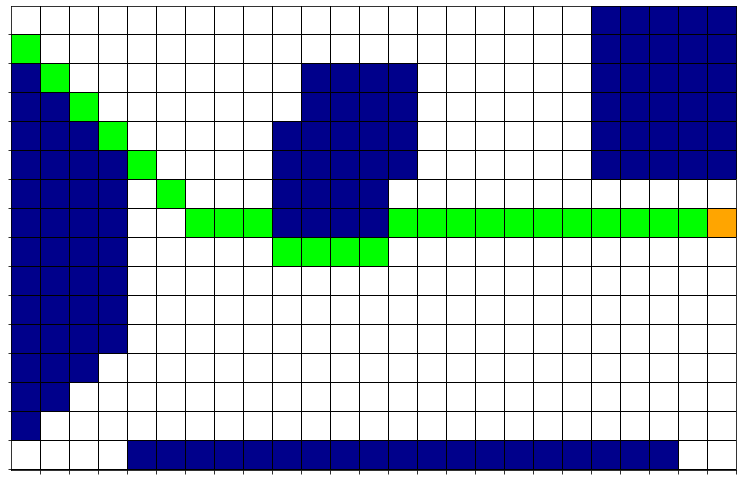

In [6]:
#general numpy help with the grid function from: https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values


#create new numpy array with zeros
grid = np.zeros(shape=(nrows,ncols))

#check if these are walls, convert them to 1
for y in range(1, nrows):
    for x in range(1, ncols):
        if((x,y) in walls):
            grid[nrows-y,x-1] = 1 


#add last final bits of wall   
grid[5, 24] = 1
grid[4, 24] = 1
grid[3, 24] = 1
grid[2, 24] = 1
grid[1, 24] = 1
grid[0, 24] = 1
grid[0, 23] = 1
grid[0, 22] = 1
grid[0, 21] = 1
grid[0, 20] = 1

    
#get solution path: 
for(x, y) in solution: 
    grid[nrows-y, x-1] = 2 
    
    
#get goal space 
grid[nrows-9, 25-1] = 3




# create discrete colormap
cmap = colors.ListedColormap(['white', 'darkblue', 'lime', 'orange'])


fig, ax = plt.subplots(figsize=(13,9))
ax.imshow(grid, cmap=cmap)

  # draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
ax.set_xticks(np.arange(0.51, 25, 1));
ax.set_xticklabels([]);
ax.set_yticks(np.arange(0.47, 16, 1));
ax.set_yticklabels([]);


plt.show()

[Back to top](#top)
<a id='p2'></a>


---
## [40 pts] Part 2:  States and Values

Winter has come, and now the area west of Engineering is icy and slippery.  As a result, there's a risk that we don't end up in the tile that we intend to move to!  In particular, if we have $k$ available actions in state $n$, the probably that we move to the state $s'$ we intend to is 75\%, and the remaining 0.25 probability is spread equally likely across all of the other adjacent (N/S/E/W/NW/NE/SE/SW) non-wall states.

In this problem, our goal is to create a policy for an agent walking in the given space west of Engineering.  Again, the goal of the agent is to navigate from start to finish, but now we want a policy for each and every location on the map.

This time, however, we're going to add the same type of randomness that our process in homework 4 had.

Because the state space is fully observable, we should be able to implement this as a Markov Decision process.


#### Part A:

Write the necessary functions to create *either* a **value iteration** or **policy iteration** scheme to solve for the MDP.  If you wish to follow the schema for homework 4, you may want to create an `MDP` class, with methods:

- `actions`, given by the valid successor states $s'$ from all actions $a$ in state $s$ in your adjacent_states from part 1.
- `rewards`, given by a significant positive reward for the goal state (e.g. 10) and a small negative reward for spending a long time in the system (e.g. non-wall reward of -0.01).
- `result`, which returns the successor state $s'$ of an *actual* movement $a$ from state $s$.
- `transition`, which returns the probability of an actual successor $s'$ given action $a$ from state $s$ using the 75\%-25% split above.


In [7]:
#NOTE - some of this class is from the HW4 solutions, some of it was from my own work on HW4
#Either way, it's been modified to work here properly 
class MDP:
    def __init__(self, nrow, ncol, terminal, default_reward, discount):
        self.nrow = nrow
        self.ncol = ncol
        states = [(x,y) for x in range(1,ncol+1) for y in range(1,nrow+1)]
        self.states = states
        self.terminal_states = terminal
        self.default_reward = default_reward
        self.df = discount

    def actions(self, state):
        if state in self.terminal_states:
            return [None]
        else:
            moves = []
            y = state[1]
            x = state[0]
            if((x, y) in walls):
                return [None]
            #as per usual, should work with adjacent states here
            #basically the opposite of the get_neighbors
            #i'm sure there's a faster way to do this, but eh
            #note that this will auto-filter for walls since adjacent neighbors won't return a wall space 
            for neighbor in adjacent_states(state):
                if neighbor not in walls: 
                    #North
                    if(neighbor == (x, y+1)):
                        moves.append('N')
                    #NorthEast
                    if(neighbor == (x+1, y+1)):
                        moves.append('NE')
                    #East
                    if(neighbor == (x+1, y)):
                        moves.append('E')
                    #SouthEast
                    if(neighbor == (x+1, y-1)):
                        moves.append('SE')
                    #South
                    if(neighbor == (x, y-1)):
                        moves.append('S')
                    #SouthWest
                    if(neighbor == (x-1, y-1)):
                        moves.append('SW')
                    #West
                    if(neighbor == (x-1, y)):
                        moves.append('W')
                    #NorthWest
                    if(neighbor == (x-1, y+1)):
                        moves.append('NW')                

            return moves 
        
        
        
    def reward(self, state):
        return self.terminal_states[state] if state in self.terminal_states.keys() else self.default_reward
        
    def result(self, state, action):
        assert action in self.actions(state), 'Error: action needs to be available in that state'
        assert state in self.states, 'Error: invalid state'
    
        if action==None:
            return state
    
        if action=='N': 
            new_state = (state[0], state[1]+1)
        elif action == 'NE':
            new_state = (state[0]+1, state[1]+1)
        elif action=='S':
            new_state = (state[0], state[1]-1)
        elif action=='SE':
            new_state = (state[0]+1, state[1]-1)
        elif action=='SW':
            new_state = (state[0]-1, state[1]-1)
        elif action=='E':
            new_state = (state[0]+1, state[1])
        elif action=='W':
            new_state = (state[0]-1, state[1])
        elif action == 'NW':
            new_state = (state[0]-1, state[1]+1)
        
        return new_state
                
    def transition(self, state, action):
        if action is None:
            return [(0, state)]
        else:
            avaliable_actions = self.actions(state)
            total_actions = len(avaliable_actions)

            #determine probability of success and fail states 
            P_success_state = 0.75; 
            P_others = 0.25 / total_actions
        
            #set up previous states
            # a list of tupes from current to total actions
            transition_states = []
           
            #get the actions from all avaliable ones! 
            for act in avaliable_actions:
                 #if we're at the current action
                if(act == action):
                    #append tuple pair of success and current action 
                    transition_states.append( (P_success_state, self.result(state, act)) )
                #otherwise, carry on with the normal reverse induction step 
                else:
                    transition_states.append( (P_others, self.result(state, act)))
                    
                
            return transition_states  
        
        

        

default_reward = -0.01
discount = 0.99
terminal = {(25,9):100} #jus one goal state cause that's the only one that leaves
mdp = MDP(nrows, ncols, terminal, default_reward, discount)


#### Part B:

Using the MDP in part 2A, implement value iteration **or** policy iteration to calculate the utilities for each state. Also implement a function that takes as arguments an MDP object and a dictionary of state-utility pairs (key-value) and returns a dictionary for the optimal policy. The optimal policy dictionary should have state tuples as keys and the optimal move (None or any of the 8 directions) as values.

In [ ]:
# i kept trying to do policy iteration but it wasn't working right. 

def value_iteration(mdp, tol=1e-3):
    utility_new = { s : 0 for s in mdp.states}
    while True: 
        
        utility_old = utility_new.copy()
        max_change = 0
        
        #check for each and every state 
        for s in mdp.states: 
            next_states = [mdp.transition(s, act) for act in mdp.actions(s)]
            
            best_utility = -999; 
            
            #calculate max espected utility! 
            for k in range(len(next_states)):
                newsum = sum([next_states[k][j][0]*utility_old[next_states[k][j][1]] for j in range(len(next_states[k]))])
                best_utility = max(best_utility, newsum)
            
            utility_new[s] = mdp.reward(s) + mdp.df * best_utility
            
            max_change = max(max_change, abs(utility_new[s]-utility_old[s]))
        
        # if maximum change in utility from one iteration to the
        # next is less than some tolerance, break
        if((mdp.df == 1 and max_change < 1) or (max_change < tol*(1-mdp.df)/mdp.df)):
            break; 
    
    return utility_new
    
    

def find_policy(mdp, utility):
    policy = {s : None for s in mdp.states}
    
    for s in mdp.states: 
        best_utility = (-999, None)
        
        for act in mdp.actions(s):
            newsum = sum([p*utility[s2] for p, s2 in mdp.transition(s,act)])
            
            #if this action has a higher expected utility than current best, replace the best
            #(utility, action) tuple with this one 
            
            if (newsum > best_utility[0]):
                best_utility = (newsum, act)
              
            
        policy[s] = best_utility[1]
    
    return policy

# result = policy_iteration(mdp)
utility = value_iteration(mdp, 0.01)
policies = find_policy(mdp, utility)


#### Part C:

Sanity check your answers in part B by listing which state has the *lowest* estimated utility (should be far from the goal!) and which states have the 3 *highest* estimated utilities.

In [ ]:
print("Utility at (1,1): ", utility.get(1,1))
print("Utility at (25,10): ", utility.get(25,10))
print("Utility at (25,8): ", utility.get(25,8))
print("Utility at (24,9): ", utility.get(24,9))

^ Yup, these values make sense. This is because the states nearest the goal ought to have a high utility because we should be incentivized to go near them, while states farthest from the goal should have a lower utility because we should be incentivized to get away from them and go somewhere better


#### Part D:

As in part 1E, make a figure.  This time, depict the optimal policy at each location.  Your choice of visualization is up to you, but I would *recommend* taking a plot similar to the maze plot in Part 1E above (or HW 2) and plotting some choice of arrows/symbols/colors corresponding to the appropriate action in each square.

In [ ]:
#general numpy help with the grid function from: https://stackoverflow.com/questions/43971138/python-plotting-colored-grid-based-on-values


#create new numpy array with zeros
grid = np.zeros(shape=(nrows,ncols))

#check if these are walls, convert them to 1
for y in range(1, nrows):
    for x in range(1, ncols):
        if((x,y) in walls):
            grid[nrows-y,x-1] = 1 


#add last final bits of wall   
grid[5, 24] = 1
grid[4, 24] = 1
grid[3, 24] = 1
grid[2, 24] = 1
grid[1, 24] = 1
grid[0, 24] = 1
grid[0, 23] = 1
grid[0, 22] = 1
grid[0, 21] = 1
grid[0, 20] = 1

    
    
#get goal space 
grid[nrows-9, 25-1] = 2




# create discrete colormap
cmap = colors.ListedColormap(['white', 'darkblue', 'orange'])


fig, ax = plt.subplots(figsize=(13,9))
ax.imshow(grid, cmap=cmap)

  # draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
ax.set_xticks(np.arange(0.51, 25, 1));
ax.set_xticklabels([]);
ax.set_yticks(np.arange(0.47, 16, 1));
ax.set_yticklabels([]);

#learned about arrows from: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.arrow.html
for state in policies:
    action = policies.get(state)
    xst, yst = state
    x = xst-1
    y = nrows-yst
    offset = 0.45

    
    if action=='N': 
        plt.arrow(x, y-offset-0.05+1, 0, -0.5,width=0.1, fc="magenta", linewidth=0) #NORTH ARROW
    elif action == 'NW':
        plt.arrow(x+offset-0.05, y+offset-0.05, -0.5, -0.5,width=0.1, fc="magenta", linewidth=0) #NORTHWEST ARROW
    elif action=='S':
        plt.arrow(x, y-offset, 0, 0.5,width=0.1, fc="magenta", linewidth=0) #SOUTH ARROW
    elif action=='SE':
        plt.arrow(x-offset+0.05, y-offset, +0.5, +0.5,width=0.1, fc="magenta", linewidth=0) #SOUTHEAST ARROW
    elif action=='SW':
        plt.arrow(x+offset-0.05, y-offset, -0.5, +0.5,width=0.1, fc="magenta", linewidth=0) #SOUTHWEST ARROW
    elif action=='E':
        plt.arrow(x-offset, y, 0.5, 0,width=0.1, fc="magenta", linewidth=0) #EAST ARROW
    elif action=='W':
        plt.arrow(1+offset, 1, -0.5, 0,width=0.1, fc="magenta", linewidth=0) #WEST ARROW
    elif action == 'NE':
        plt.arrow(x-offset+0.05, y+offset-0.05, +0.5, -0.5,width=0.1, fc="magenta", linewidth=0) #NORTHEAST ARROW



# plt.arrow(1-offset, 1, 0.5, 0,width=0.1, facecolor="magenta") #EAST
# plt.arrow(0, 0-offset, 0, 0.5,width=0.1, facecolor="magenta") #SOUTH
# plt.arrow(2, 2-offset-0.05, 0, -0.5,width=0.1, facecolor="magenta") #NORTH
#plt.arrow(1+offset, 1, -0.5, 0,width=0.1, facecolor="magenta") #WEST
#plt.arrow(1+offset-0.05, 1+offset-0.05, -0.5, -0.5,width=0.1, facecolor="magenta") #NORTHEAST
#plt.arrow(1-offset+0.05, 1+offset-0.05, +0.5, -0.5,width=0.1, facecolor="magenta") #NORTHWEST
#plt.arrow(1+offset-0.05, 1-offset, -0.5, +0.5,width=0.1, facecolor="magenta") #SOUTHWEST
#plt.arrow(1-offset+0.05, 1-offset, +0.5, +0.5,width=0.1, facecolor="magenta") #SOUTHEAST


plt.show()

[Back to top](#top)
<a id='p3'></a>


---
## [20 pts] Part 3:  The great unknown

It's nearly winter solstice, and the area west of Engineering is still icy and slippery.  

As a result, there's still a risk that we don't end up in the tile that we intend to move to!  Unfortunately, for this problem we *don't know* what that risk is, and it isn't the same everywhere.  As in Problem 2, our goal is to create a policy for an agent walking in the given space west of Engineering.  Again, the goal of the agent is to navigate from start to finish, but now we want a policy for each and every location on the map

Suppose there exists some function $f$ that measures the *footing* of state $s$.  Then if we choose to take the action "move towards state $s'$" from state $n$, the probability that we *actually arrive* in the state $s'$ we intend to is $f(s)$.  As before, the remaining $1-f(s)$ probability is spread equally likely across all of the other adjacent (N/S/E/W/NW/NE/SE/SW) non-wall states to $s$.

Because our agent can't fully observe the transitions, it's going to have to pick actions and estimate their utilities from learning.  Let's use Q-learning!

#### Part A:

Run the following code to provide a function for and a map of the footing function $f$.


In [ ]:
###YOU MAY IGNORE THIS CELL, BUT MUST RUN IT TO GENERATE F
random.seed(30)
x = np.linspace(0,25,26)
y = np.linspace(0,25,26)
X,Y = np.meshgrid(x,y)
f1 = np.zeros(X.shape)
f2 = np.zeros(X.shape)
f3 = np.zeros(X.shape)
f4 = np.zeros(X.shape)

mu1, mu2, mu3, mu4=[17,12],[17,11],[11,8],[11,6]
covar1, covar2, covar3, covar4= [[16,8],[8,16]],[[12,.5],[.5,12]],[[4,.8],[.8,4]],[[.8,12],[.8,12]]
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        f1[i,j] = 6*stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu1, cov=covar1)
        f2[i,j] = 3*stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu2, cov=covar2)
        f3[i,j] = stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu3, cov=covar3)
        f4[i,j] = 1*stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu4, cov=covar4)
        
f =f1+f2+f3+f4    
f=1-(f/np.max(f))**(1/3)

#PLOTTING:
fig, ax = plt.subplots(1,1, figsize=(7,5))
my_levels = np.linspace(0, 1, 11)
labels = [str(lv) for lv in my_levels]
cp = ax.contour(X, Y, f, levels=my_levels)
plt.clabel(cp, inline=1, fontsize=10)
ax.set(xlim=(0, 25), ylim=(0, 16))
plt.title('Footing')

In [ ]:

# You can access f directly using indices if you use the TRANPOSE of the coordinates of each point
#which this footing function does
def footing(x,y):
    return f[y,x]

print("It's icy at (12,8), with almost no footing:", footing(12,8))
print("It's better at (8,12):", footing(8,12))

#### Part B:

We're going to implement Q-learning instead of an MDP.

You will probably want to create a dictionary of the form discussed at the end of the in-class notebook for Q-learning, where each valid tuple is the first key and each valid move from that location is the second key.  You then should have the estimated utilities of each action saved in the resulting dictionary.  You may include other information if desired, but nothing else should be absolutely necessary.

After initialization, print the elements of the dictionary corresponding to the (4,4) location.  Note that there should be 7 subdictionaries for the 6 possible neighbors and the `None` action, and within each action the initial Q-value should be zero.

In [ ]:
def adjacent_states_q(state):
    #check 8 possible combinations of movement 
    x = state[0]
    y = state[1]
    neighbors = {} #empty dictionary to store neighboring values 
    
    
    #check if wall, failsafe 
    if((x,y) in walls):
        return {};
    
    #North
    if(y+1 <= nrows and (x, y+1) not in walls):
        neighbors.update({"N": 0}) #append N, pathcost 1 
    #NorthEast
    if((x+1, y+1) <= (nrows, ncols) and (x+1, y+1) not in walls):
        neighbors.update({"NE": 0}) #append NE, pathcost sqrt(2)
    #East
    if(x+1 <= ncols and (x+1, y) not in walls):
        neighbors.update({"E": 0}) #append E, pathcost 1
    #SouthEast
    if(x+1 < ncols and y-1 > 0 and (x+1, y-1) not in walls):
        neighbors.update({"SE": 0}) #append SE, pathcost sqrt(2)
    #South
    if(y-1 > 0 and (x, y-1) not in walls):
        neighbors.update({"S": 0}) #append S, pathcost 1      
    #SouthWest
    if((x-1, y-1) > (0, 0) and (x-1, y-1) not in walls):
        neighbors.update({"SW": 0}) #append SW, pathcost, pathcost sqrt(2)
    #West
    if(x-1 > 0 and (x-1, y) not in walls):
        neighbors.update({"W": 0}) #append W, pathcost 1
    #NorthWest
    if(x-1 > 0 and y+1 <= nrows and (x-1, y+1) not in walls):
        neighbors.update({"NW": 0}) #append NW, pathcost, pathcost sqrt(2)    
    
    return neighbors




#create a Q, initialize all the Q-utilities as 0.
qspaces = list(states)
#remove walls (invalid spaces)
for s in spaces:
    if s in walls: 
        space.remove(s)
        

q_dict = {}
utilities = [(0)] * len(states)
for s in qspaces:
    action_utility_dict = adjacent_states_q(s)
    q_dict.update({(s): action_utility_dict})     
    
    

print(q_dict[(1,1)]['E'])
#print(q_dict)

#### Part C:

Use the given `footing` function to modify your `transitions` from the MDP so the probabilities of result given action now flow from the icy model above.

Perform at least 1000 training epochs, where each starts at a *random* location from the valid states (this can help if find the goal state faster!).

For each epoch, take *at most* 100 actions, or until the goal is reached.  You may choose these actions by any schema you desire, but I recommend the $\varepsilon$-greedy agent that chooses the "best available" action 80% of the time and explores the other 20%. 

Show graphs depicting the actual paths taken for the last 2 of the training epochs.

In [ ]:
def qlearn(start, goal, q_dict, qspaces, numtraining = 1000, numactions = 100):
    gamma = 0.75 # Discount factor 
    alpha = 0.9 # Learning rate
    
    
    
    for i in range(numtraining):
        #randomly select a state 
        rand_index = np.random.choice(len(qspaces)-1)
        #retrieve tuple pair of state, along with corresponding actions 
        current_state = qspaces[rand_index]
        current_actions_and_values = q_dict[current_state]

        for i in range(numactions):
            action_index = np.random.choice(len(current_actions_and_values)-1)
            action = current_actions_and_values.keys()[action_index]
            
            #not entirely sure how to finish this thing....
            
            # Compute the Q-difference between where we started and where we ended up.
            QD = rewards_new[current_state,next_state] + gamma * Q[next_state, np.argmax(Q[next_state,])] - Q[current_state,next_state]

            # Update the Q-Value using the Bellman equation
            Q[current_state,next_state] += alpha * QD
    
    


qlearn(start, goal, q_dict, qspaces, 5, 10)

#### Part D:

As in part 2D, make a figure depicting the optimal policy at each location.  Does your agent actually try to avoid the ice, compared to how it behaved in the MDP in Part 2?